<a href="https://colab.research.google.com/github/Srivardini/Artificial_star/blob/main/SNR_for_Proxima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [ ]:
!pip install photutils --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00


# **Imports**

In [ ]:
import os

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.nddata import CCDData
from astropy.io import fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

import matplotlib.colors as col
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm

from photutils.datasets import make_random_gaussians_table, make_gaussian_sources_image

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats

import photutils as phot
from photutils.background import Background2D, MedianBackground, MeanBackground

from astropy.modeling import models, fitting

import pandas as pd

In [ ]:
import astropy.stats as stats

In [ ]:
from astropy.convolution import Gaussian2DKernel, convolve_fft

In [ ]:
# To improve Aesthetics of plots
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)
matplotlib.rcParams['font.size'] = 15

# **Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Detecting Proxima**

In [ ]:
cd '/content/drive/MyDrive/MRes + PhD/August 8, 2023/Proxima SNR'

/content/drive/MyDrive/MRes + PhD/August 8, 2023/Proxima SNR


In [ ]:
def detect_stars(data, threshold = None, sigma=3, fwhm = 20.0):

  fwhm = 20.0 # Full Width at Half Maximum (approximate stellar size)

  if threshold is None:
    sigma_clip = stats.SigmaClip(sigma=sigma)
    bkg_estimator = MedianBackground()
    filter_size = (3, 3)
    box_size = 200
    bkg = Background2D( data,
                        box_size,
                        filter_size=filter_size,
                        sigma_clip=sigma_clip,
                        bkg_estimator=bkg_estimator)



    threshold_img = bkg.background + (3*bkg.background_rms)
    threshold_float = 3.5*bkg.background_rms_median

  else:

    threshold_img = threshold
    threshold_float = 3.5*np.median(threshold)

  sigma = 20*stats.gaussian_fwhm_to_sigma  # FWHM = 20
  kernel = Gaussian2DKernel(x_stddev=sigma)

  convolved_data = convolve_fft(data - threshold_img,kernel)

  daofind = DAOStarFinder(threshold_float, fwhm)

  sources = daofind(convolved_data)

  return sources, threshold_img

In [ ]:
def perform_photometry(sources, data, r = 50):
  positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
  apertures = CircularAperture(positions, r=r)
  bags = CircularAnnulus(positions,r+10,r+30)

  phot_table = aperture_photometry(data, [apertures,bags])

  phot_table['sky_flux'] = phot_table['aperture_sum_1']*apertures.area/bags.area
  # calculate source flux
  phot_table['flux'] = phot_table['aperture_sum_0'].value - \
      phot_table['sky_flux'].value
  # calculate error on the source flux
  phot_table['flux_err'] = np.sqrt(phot_table['flux'].value +
                                    phot_table['sky_flux'].value)

  # calculate signal to noise ratio
  phot_table['SNR'] = phot_table['flux']/phot_table['flux_err']

  return phot_table, apertures

# **Flux variation at a given exposure time**

In [ ]:
exps = os.listdir()
exps = [i for i in exps if '2023' in i]
exp = exps[4]

In [ ]:
files = [i for i in os.listdir(exp) if 'txt' not in i and 'FIT' in i]

star_flux = []
x_pos   = []
y_pos   = []
sky_flux = []
SNRS = []

threshold = None

for i,f in enumerate(files):
  hdul = fits.open(f'{exp}/{f}')
  img = hdul[0].data/hdul[0].header['EXPTIME']

  # Source is detected on only first image
  #if 1 : #threshold is None:
  sources, threshold = detect_stars(img, sigma = 5)

  phot_table, _ = perform_photometry(sources,img, r=40)

  # Selecting Proxima

  # To be used when Proxima isn't that star with highest SNR
  x_cut = phot_table #[(phot_table['xcenter'].value>1275) & (phot_table['xcenter'].value<1350)]
  y_cut = x_cut #[(x_cut['ycenter'].value>300) & (x_cut['ycenter'].value<500)]

  flux_cut = y_cut[y_cut['SNR']== y_cut['SNR'].max()]
  positions = np.transpose([flux_cut['xcenter'].value, flux_cut['ycenter'].value])
  apertures = CircularAperture(positions, r = 50)

  star = flux_cut['flux'].value[0]
  sky = flux_cut['sky_flux'].value[0]
  SNR = flux_cut['SNR'].value[0]
  x = flux_cut['xcenter'].value[0]
  y = flux_cut['ycenter'].value[0]

  star_flux.append(star)
  sky_flux.append(sky)
  x_pos.append(x)
  y_pos.append(y)
  SNRS.append(SNR)

  # For Visualizing while debugging
  plt.imshow(img, cmap='jet', norm=col.LogNorm())
  apertures.plot(color='red', lw=2)
  plt.title(f'Exposure Time :0.10s')
  plt.axis('off')
  plt.show()

  print(i,x,y,star,sky,SNR)




In [ ]:
hdul[0].header

In [ ]:
hdul[0].header

In [ ]:
import pandas as pd

df = pd.DataFrame(data= { 'x': x_pos, 'y': y_pos, 'Star': star_flux, 'Sky': sky_flux, 'SNR': SNRS})
df.to_csv('/content/SNR_values_0.10s.csv')
df

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(star_flux, 'ko-')
ax.set_xlabel('Frames')
ax.set_ylabel('Star_Flux')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_title('Exposure_time_0.10s')
plt.grid()

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(sky_flux, 'ko-')
ax.set_xlabel('Frames')
ax.set_ylabel('Sky_Flux')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_title('Exposure_time_0.10s')

plt.grid()

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(SNRS, 'ko-')
ax.set_xlabel('Frames')
ax.set_ylabel('SNR')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_title('Exposure_time_0.10s')
plt.grid()

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(x_pos,y_pos, c = np.linspace(0,1,100))
ax.set_xlabel('X Pos')
ax.set_ylabel('Y Pos')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_title('Exposure_time_0.10s')
plt.grid()

# **SNR vs Exposure Time**

In [ ]:
exps = os.listdir()
exps = [i for i in exps if '2023' in i]

exptimes = []
exp_flux = []
exp_flux_std = []
exp_sky = []
exp_sky_std = []
exp_SNR = []
exp_SNR_std = []

for exp in exps:
  files = [i for i in os.listdir(exp) if 'txt' not in i and 'FIT' in i]

  star_flux = []
  sky_flux = []
  SNRS = []

  threshold = None
  for f in files:
    hdul = fits.open(f'{exp}/{f}')
    img = hdul[0].data/hdul[0].header['EXPTIME']

    if threshold is None:
      sources, threshold = detect_stars(img, threshold, 5)

    phot_table, _ = perform_photometry(sources,img)

    # Selecting Proxima

    # To be used when Proxima isn't that star with highest SNR
    x_cut = phot_table  #[(phot_table['xcenter'].value>1300) & (phot_table['xcenter'].value<1700)]
    y_cut = x_cut  #[(x_cut['ycenter'].value>300) & (x_cut['ycenter'].value<1000)]

    flux_cut = y_cut[y_cut['SNR']== y_cut['SNR'].max()]
    positions = np.transpose([flux_cut['xcenter'].value, flux_cut['ycenter'].value])
    apertures = CircularAperture(positions, r = 30)

    star = flux_cut['flux'].value[0]
    sky = flux_cut['sky_flux'].value[0]
    SNR = flux_cut['SNR'].value[0]

    star_flux.append(star)
    sky_flux.append(sky)

    SNRS.append(SNR)

  exp_flux.append(np.median(star_flux))
  exp_flux_std.append(np.std(star_flux))

  exp_sky.append(np.median(sky_flux))
  exp_sky_std.append(np.std(sky_flux))

  exp_SNR.append(np.median(SNRS))
  exp_SNR_std.append(np.std(SNRS))

In [ ]:
x = np.array(exptimes)
ind = np.argsort(x)
x = x[ind]
y = np.array(exp_SNR)[ind]

plt.plot(x,y,'ko-')
plt.xlabel('Exposure time (s)')
plt.ylabel('SNR')

# **Scintillation and Median SNR vs Exposures**

In [ ]:
cd /content/drive/MyDrive/MRes + PhD/Proxima_Data_reduction_8 8 23/CSV_files

/content/drive/MyDrive/MRes + PhD/Proxima_Data_reduction_8 8 23/CSV_files


In [ ]:
ls

 SNR_values_0.05s.csv   SNR_values_0.40s.csv  'SNR_values_0.65s (1).csv'
 SNR_values_0.15s.csv   SNR_values_0.45s.csv   SNR_values_0.70s.csv
 SNR_values_0.20s.csv   SNR_values_0.49s.csv   SNR_values_0.75s.csv
 SNR_values_0.25s.csv   SNR_values_0.55s.csv   SNR_values_0.80s.csv
 SNR_values_0.35s.csv   SNR_values_0.60s.csv   SNR_values_0.85s.csv


In [ ]:
exps = os.listdir()
SNR_exposure = []
exposure = [0.05,0.15,0.20,0.25,0.35,0.40,0.45,0.49,0.55,0.60,0.65,0.70,0.75,0.80,0.85]
median = []
SNRS = []

for i in exps:
  file_1 = pd.read_csv(f'{i}')
  median1 = file_1['SNR'].median()

  median.append(median1)
  SNR_exposure.append(file_1)
  SNRS.append(file_1['SNR'].values[:100])

tb_SNR = pd.DataFrame(data ={'Exposure':exposure,'SNR':median})
tb_SNR

,Exposure,SNR
0,0.05,111.185660
1,0.15,235.332502
2,0.20,278.720940
3,0.25,543.975199
4,0.35,490.012574
5,0.40,388.958336
6,0.45,726.905320
7,0.49,732.064264
8,0.55,804.346175
9,0.60,801.401552


In [ ]:
SNRS = np.array(SNRS)

In [ ]:
SNR_tab = Table.from_pandas(tb_SNR)

In [ ]:
SNR_tab['SNRS'] = SNRS

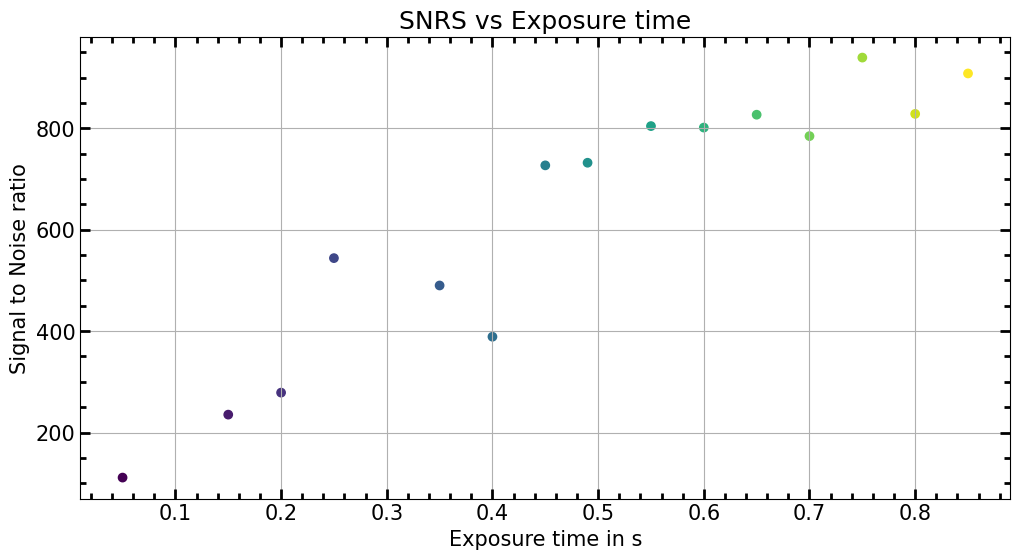

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
ax.scatter(exposure,median, c = np.linspace(0,1,15))
ax.set_xlabel('Exposure time in s')
ax.set_ylabel('Signal to Noise ratio')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_title('SNRS vs Exposure time')
plt.grid()


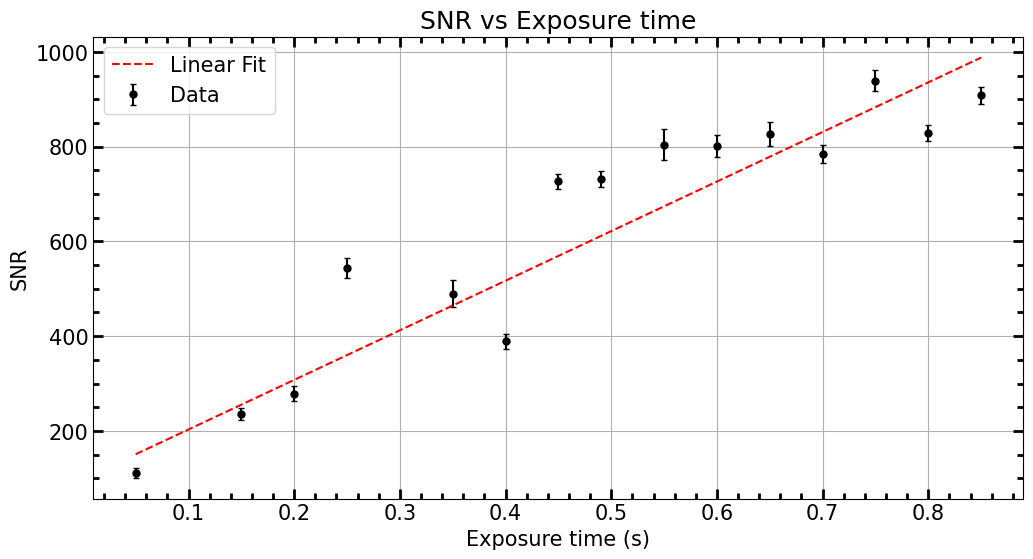

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
x = exposure
y = np.median(SNR_tab['SNRS'].value,axis=1)
yerr = SNR_tab['SNRS'].value.std(axis = 1)
ax.errorbar(x,y,yerr,fmt='o', color = 'black', markersize=5, capsize=2)

ax.set_xlabel('Exposure time (s)')
ax.set_ylabel(r'SNR')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_title('SNR vs Exposure time')

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init, x,y,weights=1/yerr)
ax.plot(x,model(x),'--',color='red')
plt.grid()
plt.legend(['Linear Fit', 'Data'])


In [ ]:
help(fit)

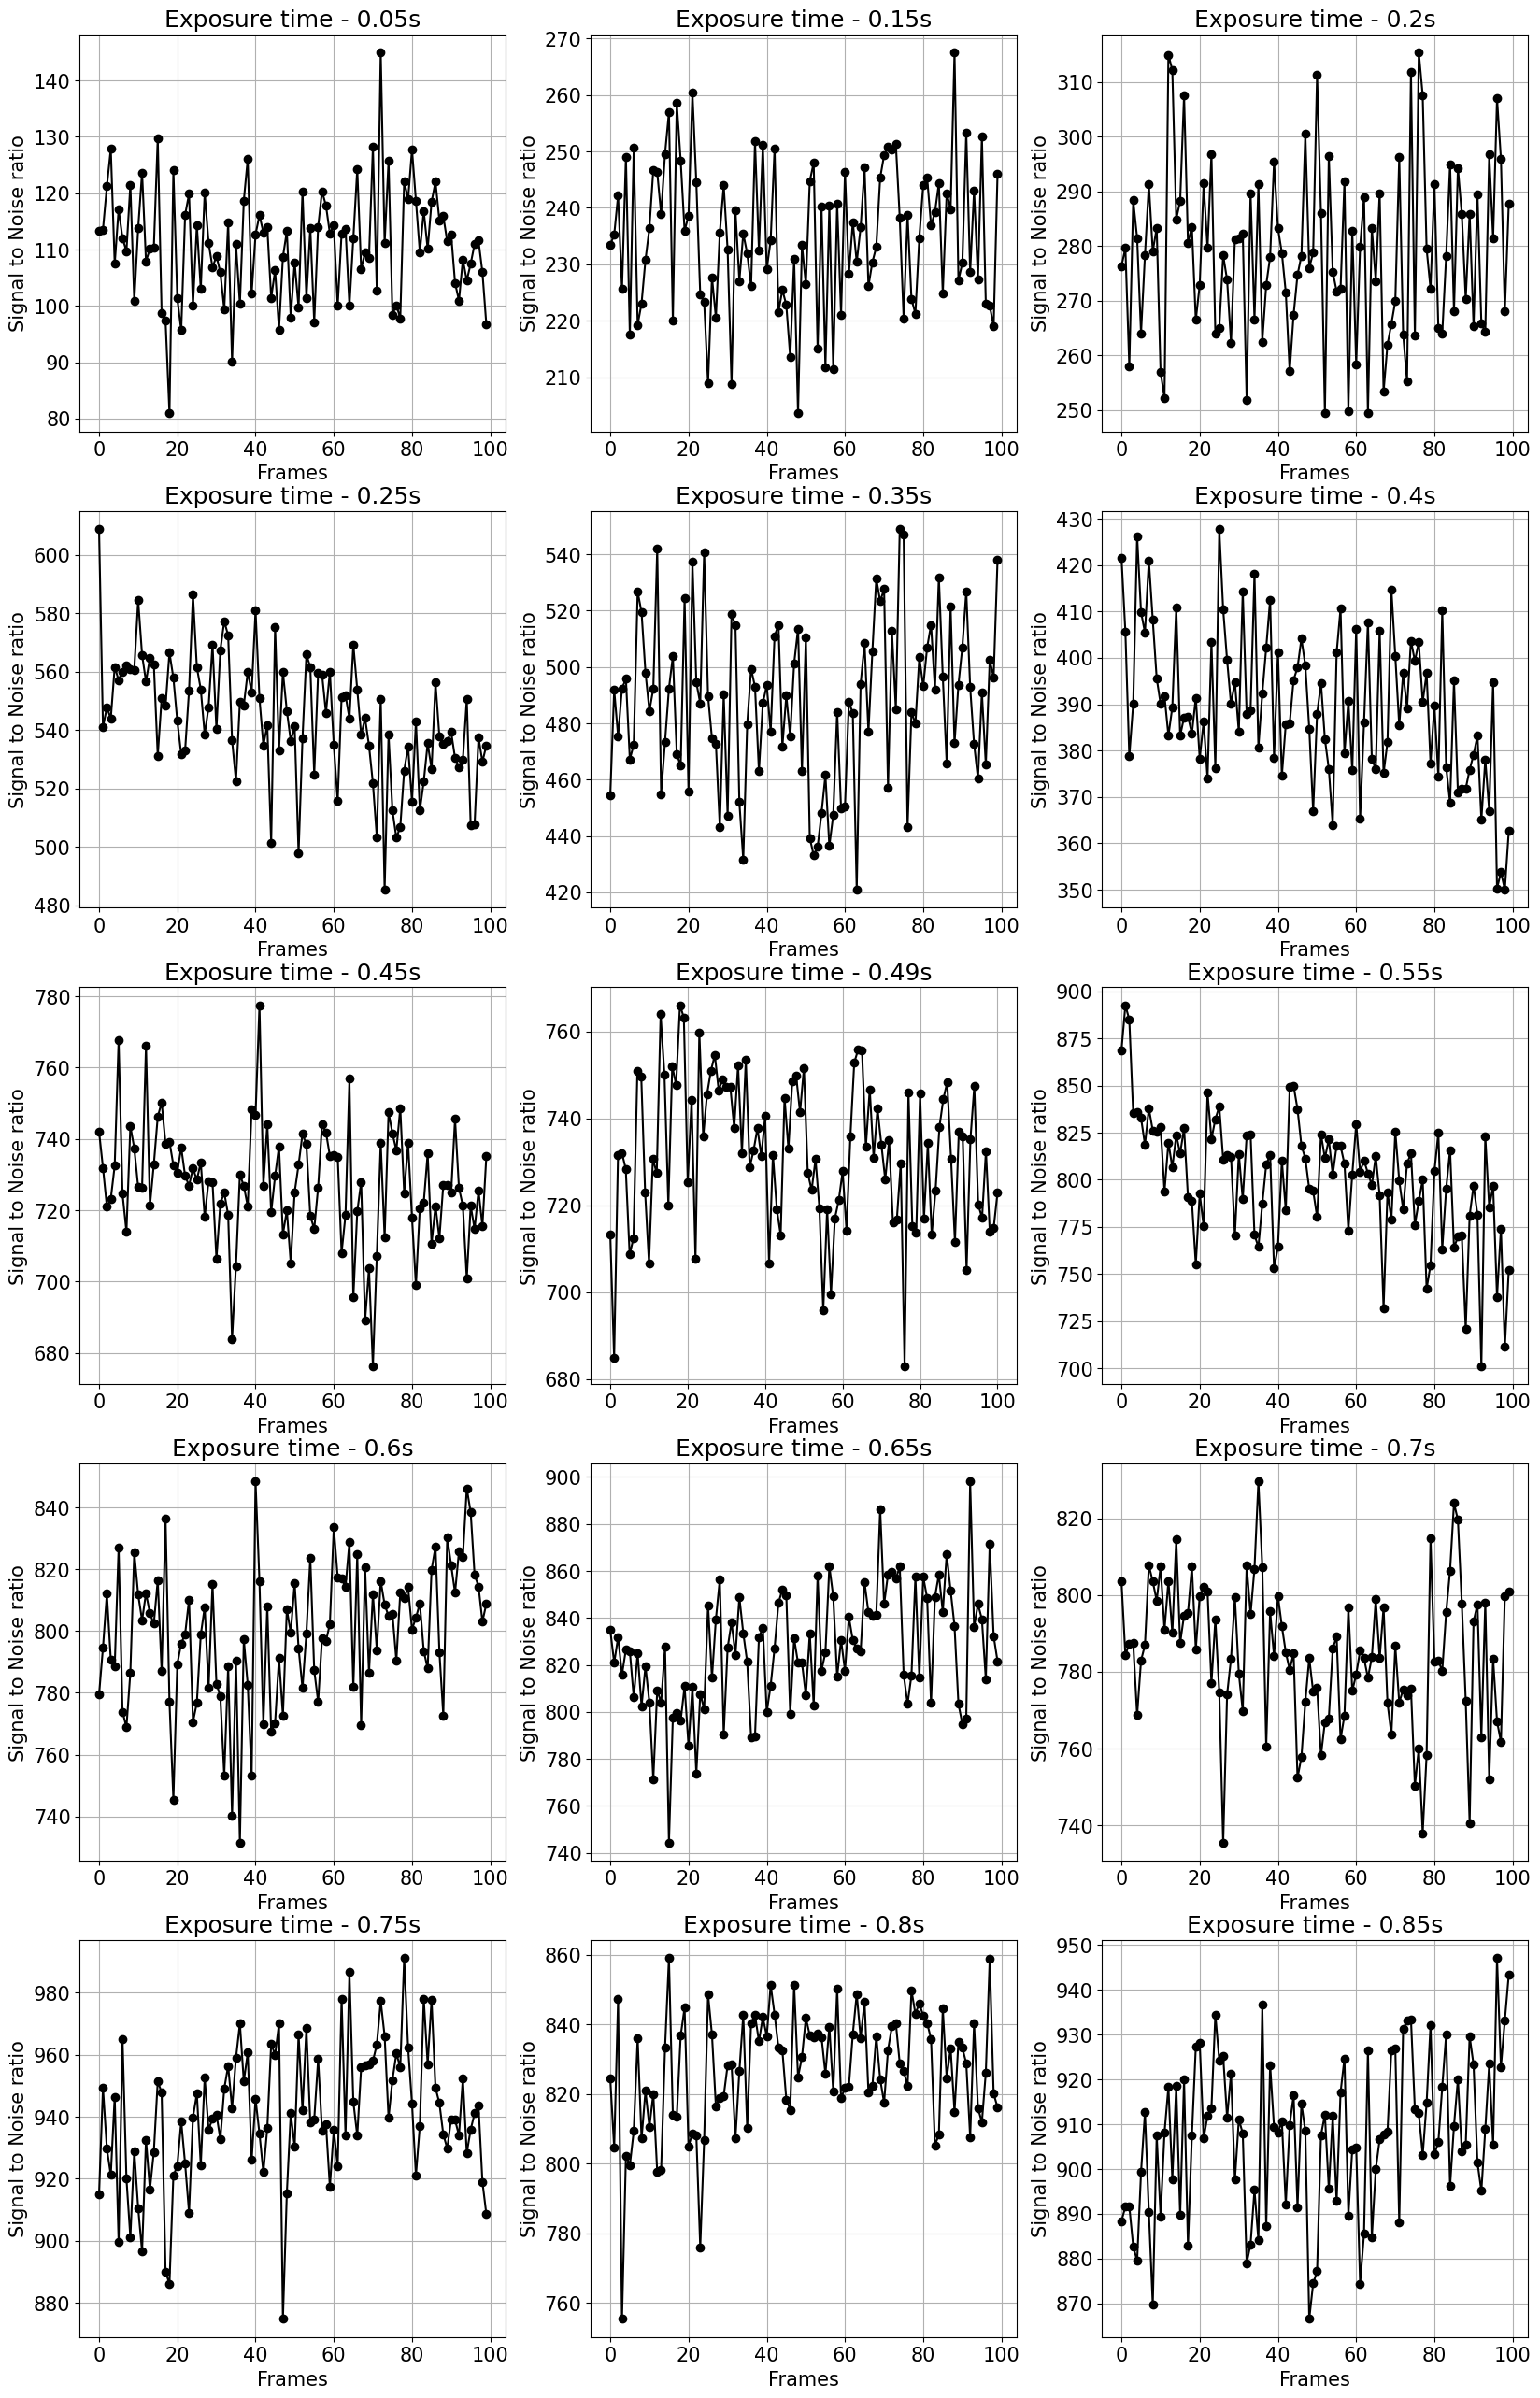

In [ ]:
k = 0

fig, ax = plt.subplots(5,3,figsize=(20,32))
for i in [0,1,2,3,4]:
  for j in [0,1,2]:
    ax[i,j].plot(SNR_exposure[k]['SNR'].values, 'ko-')
    ax[i,j].set_xlabel('Frames')
    ax[i,j].set_ylabel('Signal to Noise ratio')
    ax[i,j].set_title('Exposure time - ' f'{exposure[k]}''s')
    ax[i,j].grid()
    k+=1

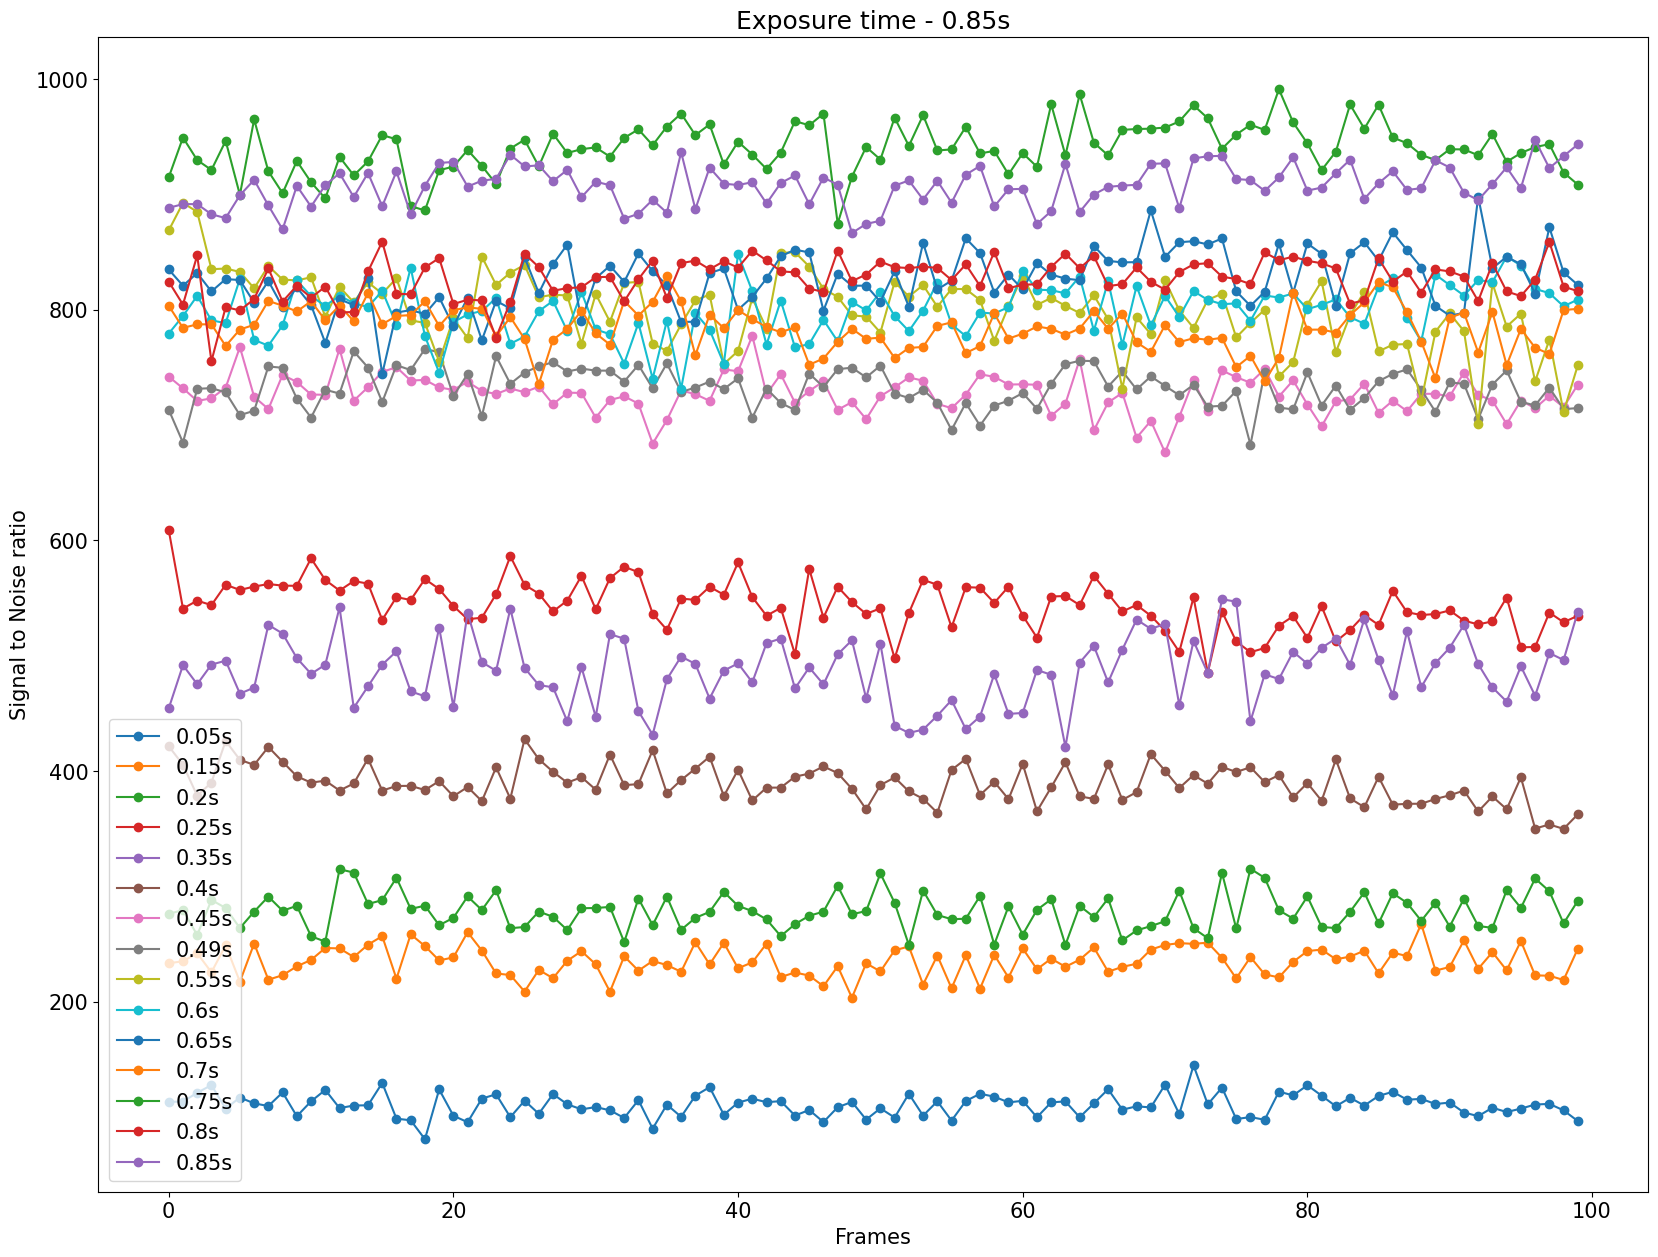

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
for  exp, SNR in zip(SNR_tab['Exposure'],SNR_tab['SNRS']):
    ax.plot(SNR, 'o-')
ax.set_xlabel('Frames')
ax.set_ylabel('Signal to Noise ratio')
ax.set_title('Exposure time - ' f'{exp}''s')

ax.legend([str(i)+ 's' for i in SNR_tab['Exposure']])